In [1]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
dataset_dirnames = ['toy_dataset', 'fs_300']
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)  # Load and clean datasets
methods_to_compare = ['Percival14', 'Zapata14', 'Degara12', 'Bock15', 'Gkiokasq8', 'RekBox']
%matplotlib inline

# This notebook contains excerpts from the article: "Tempo Estimation for Music Loops and a Simple Confidence Measure" 
# TODO proper reference
# License: CC-BY-4.0

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Overall tempo estimation accuracy

Similarly to previous tempo estimation works, we follow the methodology described by Gouyon et al. [1] to test the aforementioned algorithms against the four collected datasets. 
In addition the standard *Accuracy 1* and *Accuracy 2* measures (with 4% tolerance), we add an extra measure that we call *Accuracy 1e* and that represents the percentage of instances whose estimated BPM is exactly the same as the ground truth after rounding the estimated BPM to the nearest integer. Accuracy 1e is therefore more strict than Accuracy 1.
The reason why we added this extra accuracy measure is that, imagining a music creation context where loops can be queried in a database, it is of special relevance to get returned instances whose BPM exactly matches that specified as target.

The overall accuracy results show that Percival14 obtains the highest accuracy scores for all accuracy measures and all datasets except for the LOOP dataset, in which highest score for Accuracy 1 is obtained by Zapata14 (see Figure 1 in the cell below). Considering the data from all datasets at once, mean accuracy values for Percival14 range from 47% (Accuracy 1e) to 73% (Accuracy 2), with an average increase of 7% accuracy when compared with the second best-scored method. With a few exceptions, pairwise accuracy differences between Percival14 and the second best-scored method in all datasets and accuracy measures are statistically significant using McNemar's test and a significance value of $\alpha=0.01$ (i.e.,~$p \ll 0.01$). 
We also observe that accuracies for the APPL dataset tend to be higher than for other datasets. This can be explained by the fact that APPL contains professionally created and curated loops, while the other datasets contain user contributed content, not necessarily created by professionals (Mixcraft's loop library also contains content gathered from online repositories).

[1] Fabien Gouyon, Anssi Klapuri, Simon Dixon, Miguel Alonso, George Tzanetakis, Christian Uhle, and Pedro Cano. An Experimental Comparison ofAudio Tempo Induction Algorithms. IEEE Transactions on Audio, Speech and Language Processing, 14(5):1832–1844, 2006.





General tempo estimation results (TOYDS)
*****************************************


Method       Accuracy 1e   Accuracy 1   Accuracy 2   
-----------------------------------------------------
Percival14   40.00         40.00        80.00        
Zapata14     40.00         60.00        70.00        
Bock15       30.00         50.00        70.00        
RekBox       40.00         60.00        60.00        
Degara12     20.00         40.00        50.00        
Gkiokasq8    0.00          0.00         0.00         


General tempo estimation results (fs_300)
******************************************


Method       Accuracy 1e   Accuracy 1   Accuracy 2   
-----------------------------------------------------
Percival14   32.32         45.45        58.59        
Bock15       15.15         22.22        52.53        
Zapata14     29.29         49.49        50.51        
Degara12     26.26         48.48        49.49        
Gkiokasq8    0.00          0.00         0.00         
RekBox       0

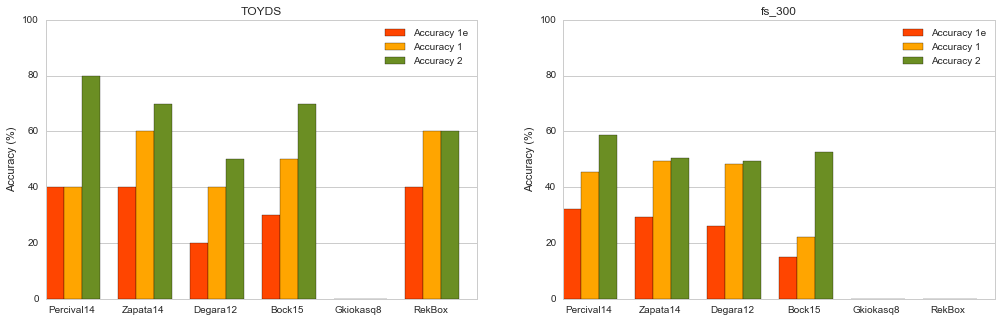


**Figure 1**: Overall tempo estimation accuracies.



General tempo estimation results (ALL DATASETS)
-----------------------------------------------

Method       Accuracy 1e   Accuracy 1   Accuracy 2   Mean accuracy   
---------------------------------------------------------------------
Percival14   33.03         44.95        60.55        46.18           
Zapata14     30.28         50.46        52.29        44.34           
Degara12     25.69         47.71        49.54        40.98           
Bock15       16.51         24.77        54.13        31.80           
RekBox       3.67          5.50         5.50         4.89            
Gkiokasq8    0.00          0.00         0.00         0.00            


In [2]:
# Prepare figure
n_datasets = len(datasets)
if not n_datasets:
    raise Exception("No datasets were specified or could be loaded!")
nrows = int(math.ceil(float(n_datasets)/2))
ncols = 1 if n_datasets < 2 else 2
fig1, axs = plt.subplots(nrows, ncols, figsize=(17, 5))

# Run analysis and plot results
all_datasets_method_results = dict()
for count, dataset in enumerate(datasets):
    print title("\nGeneral tempo estimation results (%s)" % dataset.short_name, c='*')
    methods_to_compare = methods_to_compare
    table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2']
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = dict()
        try:
            table_row = [method]
            for accuracy_func in accuracy1e, accuracy1, accuracy2:
                method_results = accuracy_func(dataset.data, method)
                table_row.append(100 * basic_statistics(method_results)['avg'])
                if accuracy_func.__name__ not in all_datasets_method_results[method]:
                    all_datasets_method_results[method][accuracy_func.__name__] = list()
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
            table_rows.append(table_row)
        except IndexError:
            print "Warning: Skipping method %s (analsyis not found in dataset)" % method
            continue
    print ""
    print_table(table_header, table_rows, sort_column=3, highlight_max=True)
    
    if n_datasets == 1:
        ax = axs
    elif n_datasets == 2:
        ax = axs[count]
    else:
        ax_col=count/2
        ax_row=count%2
        ax = axs[ax_col,ax_row]
        
    N = len(methods_to_compare)
    ind = np.arange(N)
    accuracy_1e_means = [row[1] for row in table_rows]
    accuracy_1_means = [row[2] for row in table_rows]
    accuracy_2_means = [row[3] for row in table_rows]
    width = 0.25
    rects1 = ax.bar(ind, accuracy_1e_means, width, color=COLORS[0])
    rects2 = ax.bar(ind + width, accuracy_1_means, width, color=COLORS[1])
    rects3 = ax.bar(ind + 2*width, accuracy_2_means, width, color=COLORS[2])
    ax.set_title(dataset.short_name)
    ax.set_xticks(ind + 1.4 * width)
    ax.set_xticklabels([method for method in methods_to_compare], rotation=0)
    ax.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy 1e', 'Accuracy 1', 'Accuracy 2'))
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)
    
plt.show()
figure_caption = """
**Figure 1**: Overall tempo estimation accuracies.
"""
IPython.display.display(IPython.display.Markdown(figure_caption))

# Show results for all datasets combined
print title("General tempo estimation results (ALL DATASETS)")
table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2', 'Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results.items():
    table_row = [method]
    for accuracy_measure, data in results.items():
        table_row.append(100 * basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=4, highlight_max=True)

In [3]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print ""
    print title('Statistical tests for dataset %s' % dataset.short_name)    
    for accuracy_func in accuracy1e, accuracy1, accuracy2:
        print '\nMeasure: %s' % accuracy_func.__name__
        table_header = [' '] + [method for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([method_a] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset TOYDS
-----------------------------------


Measure: accuracy1e
             Percival14   Zapata14   Degara12   Bock15   Gkiokasq8   RekBox   
------------------------------------------------------------------------------
Percival14   -            0.617      0.617      1        0.134       0.683    
Zapata14     0.617        -          0.617      1        0.134       0.48     
Degara12     0.617        0.617      -          1        0.48        0.48     
Bock15       1            1          1          -        0.248       1        
Gkiokasq8    0.134        0.134      0.48       0.248    -           0.134    
RekBox       0.683        0.48       0.48       1        0.134       -        

Measure: accuracy1
             Percival14   Zapata14   Degara12   Bock15   Gkiokasq8   RekBox   
------------------------------------------------------------------------------
Percival14   -            0.683      0.683      1        0.134       0.683    
Zapata14     0.

## Accuracy vs confidence measure

Figure 2 (see cells below) shows the accuracy of the three best-scoring tempo estimation algorithms and the number of instances remaining in the dataset when filtering by different values of a confidence threshold $\gamma$.
As we expected, we can see how accuracy increases with $\gamma$ but the number of instances decreases.
Interestingly, we observe that the number of instances decays later for estimations performed with Percival14 algorithm than for the other algorithms.
This reflects the fact that Percival14 produces better BPM estimates.

In [4]:
# Confidence measure function
# NOTE: to speed up this process here we have already precomputed the effective start and end positions 
# acocrding to the envelope
def compute_confidence_measure(estimated_bpm,
                       duration_samples,
                       start_effective_duration,
                       end_effective_duration,
                       sample_rate=44100, beat_range=range(1, 128), k=0.5):
    if estimated_bpm == 0:
        # This condition is to skip computing other steps if estimated bpm is 0, we already know that the
        # output will be 0
        return 0

    durations_to_check = [
        duration_samples,
        duration_samples - start_effective_duration,
        end_effective_duration,
        end_effective_duration - start_effective_duration
    ]

    beat_duration = (60.0 * sample_rate)/estimated_bpm
    L = [beat_duration * n for n in beat_range]
    thr_lambda = k * beat_duration
    confidences = list()
    for duration in durations_to_check:
        delta_l = min([abs(l - duration) for l in L])
        if delta_l > thr_lambda:
            confidences.append(0.0)
        else:
            confidences.append(1.0 - float(delta_l) / thr_lambda)
    return max(confidences)

# Iterate over all instances in all datasets and for all methods
print 'Computing confidence measure values for all sounds in all datasets and for all methods...',
n_annotated = 0
for dataset in datasets:
    for key, item in dataset.data.items():
        for method in methods_to_compare:
            try:
                item['analysis'][method]['confidence_ffont'] = compute_confidence_measure(
                    int(round(item['analysis'][method]['bpm'])),  
                    item['analysis']['durations']['length_samples'],
                    item['analysis']['durations']['start_effective_duration'], 
                    item['analysis']['durations']['end_effective_duration']
                )
                n_annotated += 1
            except KeyError:
                continue
print 'done! \n%i annotations done' % n_annotated
if n_annotated == 0:
    print 'It looks like no instances have been annotated. Make sure that the dataset has been properly analysed.'

Computing confidence measure values for all sounds in all datasets and for all methods... done! 
442 annotations done



Confidence vs tempo estimation accuracy (TOYDS)
-----------------------------------------------



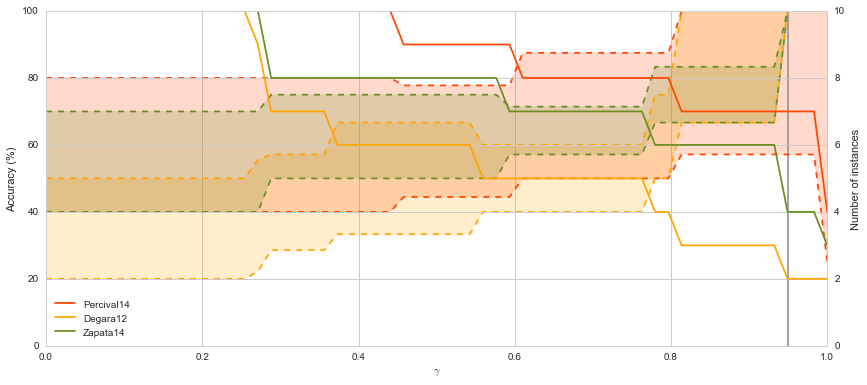

**Figure 2 - TOYDS **: Accuracy vs confidence measure for TOYDS dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    


Confidence vs tempo estimation accuracy (fs_300)
------------------------------------------------



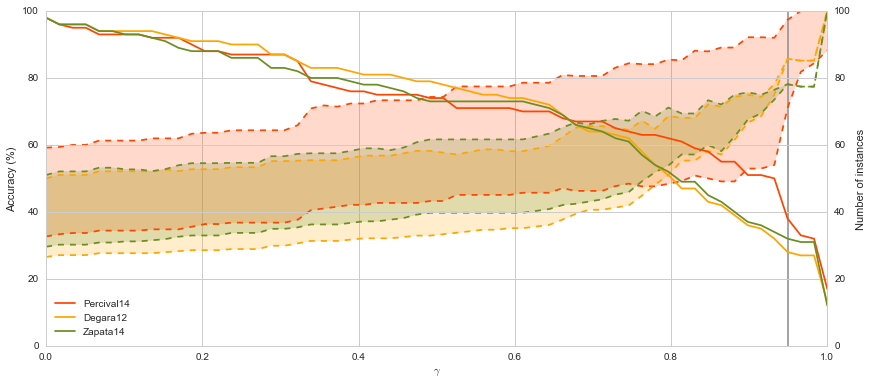

**Figure 2 - fs_300 **: Accuracy vs confidence measure for fs_300 dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    

In [5]:
# Now do all the plotting

for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    ax2 = ax1.twinx()

    for count, method in enumerate(['Percival14', 'Degara12', 'Zapata14']):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
                accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
                accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
                accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=method)

    print title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(0.95, 0, 100, color='#999999')  # 95% confidence threshold
    plt.show()
    figure_caption = """**Figure 2 - %s **: Accuracy vs confidence measure for %s dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    """ % (dataset.short_name, dataset.short_name)
    IPython.display.display(IPython.display.Markdown(figure_caption))

### Accuracy results for confidence > 95%

Filtering by the confidence measure, a potential user searching for loops in a dataset could define a minimum threshold to get more accurate results at the expense of getting less loops returned. 
For instance, if we set a hard confidence threshold of $\gamma=0.95$, we find that the accuracies for Percival14 method range, on average, from 67% (Accuracy 1e) to 92% (Accuracy 2) while preserving an average of 52% of the instances. 
Interestingly enough, we observe that when setting that hard threshold, reported RekBox accuracies outperform these of Percival14 in all datasets, with an average increase ranging from 2% for Accuracy 2 to 14% for Accuracy 1e (all statistically significant with $p \ll 0.01$). 

We attribute this to the fact that RekBox seems to have a built-in confidence measure thresholding step in which the algorithm outputs 0 BPM when the analysis does not meet certain confidence requirements. Therefore, once filtering the datasets by $\gamma$ (even with small values), all those instances whose BPM estimation is 0 BPM get discarded. Nevertheless, it is also important to note that filtering with the hard threshold, RekBox only preserves an average of 31% of the instances (lower than the 52% reported above by Percival14).

In [6]:
# Accuracy for for confidence threshold > 95%
conf_threshold = 0.95
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in methods_to_compare:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(accuracy1e(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(accuracy2(filtered_data, method))['avg']
        except IndexError:
            print 'Unable to compute results for method %s and dataset %s' % (method, dataset.short_name)
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)
print ''
print_table(table_header, table_rows)

Unable to compute results for method Gkiokasq8 and dataset TOYDS
Unable to compute results for method Gkiokasq8 and dataset fs_300
Unable to compute results for method RekBox and dataset fs_300

Method       TOYDS                       fs_300                    
-------------------------------------------------------------------
Percival14   A=57.14 - 100.00%, N=70%    A=71.05 - 97.37%, N=38%   
Zapata14     A=100.00 - 100.00%, N=40%   A=78.12 - 78.12%, N=32%   
Degara12     A=100.00 - 100.00%, N=20%   A=85.71 - 85.71%, N=28%   
Bock15       A=60.00 - 100.00%, N=50%    A=43.33 - 93.33%, N=30%   
Gkiokasq8    -                           -                         
RekBox       A=80.00 - 100.00%, N=50%    -                         


/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [7]:
# Run pairwise statistical tests when filtering by 95% confidence
alpha = 0.01
conf_threshold = 0.95

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print ""
    print title('Statistical tests for dataset %s' % dataset.short_name)    
    for accuracy_func in accuracy1e, accuracy1, accuracy2:
        print '\nMeasure: %s' % accuracy_func.__name__
        table_header = [' '] + [method for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    filtered_data_a = dataset.filter_data([('analysis.%s.%s__>=' % (method_a, 'confidence_ffont'), conf_threshold)]).data
                    filtered_data_b = dataset.filter_data([('analysis.%s.%s__>=' % (method_a, 'confidence_ffont'), conf_threshold)]).data
                    result = compute_mcnemar_test(accuracy_func(filtered_data_a, method_a), accuracy_func(filtered_data_b, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([method_a] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset TOYDS
-----------------------------------


Measure: accuracy1e
             Percival14   Zapata14   Degara12   Bock15   Gkiokasq8   RekBox   
------------------------------------------------------------------------------
Percival14   -            0.617      0.617      1        0.134       0.683    
Zapata14     0.48         -          0.248      0.48     0.134       1        
Degara12     1            1          -          1        0.48        0*       
Bock15       1            1          0.48       -        0.248       0*       
Gkiokasq8    0*           0*         0*         0*       -           0*       
RekBox       0.617        0.48       0.48       1        0.134       -        

Measure: accuracy1
             Percival14   Zapata14   Degara12   Bock15   Gkiokasq8   RekBox   
------------------------------------------------------------------------------
Percival14   -            1          1          0.683    0.134       1        
Zapata14     0.

## Combined accuracy and confidence measure

Besides the overall accuracy measurements, we are also interested in observing how accuracy varies according to the confidence values that we estimate.
We can intuitively imagine that if we filter our datasets and only keep loops whose estimated confidence for the BPM prediction is above a certain confidence threshold, the overall accuracy results will increase. 
However, the higher we set the minimum confidence threshold, the smaller the size of filtered dataset will be.
Hence, we want to quantify the relation between the overall accuracy and the total number of music loops that remain in a dataset after filtering by minimum confidence.
To do that, given one of the aforementioned accuracy measures, we can define a minimum confidence threshold $\gamma$ and a function $A(\gamma)$ that represents overall BPM estimation accuracy when only evaluating loop instances whose estimated confidence value is above $\gamma$ for a given dataset and tempo estimation algorithm.
Similarly, we can define another function $N(\gamma)$ which returns the percentage of instances remaining in a dataset after filtering out those whose estimated confidence value (for a given tempo estimation method) is below $\gamma$. $A(\gamma)$ and $N(\gamma)$ can be understood as standard precision and recall curves, and therefore we can define a combined score measure $S(\gamma)$ doing the analogy with an f-measure computation:

$$ S(\gamma) = 2 \cdot \frac{A(\gamma) \cdot N(\gamma)}{A(\gamma) + N(\gamma)}.$$

An overall score for a given dataset, tempo estimation algorithm and accuracy measure can thus be given by taking the mean of $S(\gamma)$, $\bar S$. After computing $\bar S$ with our data, we again find that Percival14 obtains the best score in all datasets and for all accuracy measures (i.e.~for $A(\gamma)$ computed with Accuracy 1e, Accuracy 1 or Accuracy 2). This means that Percival14 offers the overall best balance between estimation accuracy and number of preserved instances in the dataset when filtering by a minimum confidence threshold.

In [8]:
# NOTE: To run this cell, confidence measures need to be computed first (see cells above)

def overall_method_score(accuracies, counts, dataset_size):
    """
    We normalize the counts to the dataset size so scores provided by datasets of different sizes are comparable.
    We also normalize accuracy values to go from 0 to 1 instead of from 0 to 100.
    Finally we divide the result by the number of bins of the histogram so that using histograms of different resolution
    should return similar results.
    """
    overall_score = 0.0
    length = len(counts)  # Should be the same as len(accuracies)
    for i in range(length):
        overall_score += 2 * ((float(counts[i])/dataset_size) * (float(accuracies[i])/100)) / ((float(counts[i])/dataset_size) + (float(accuracies[i])/100))
    return overall_score/length

for accuracy_func in accuracy1e, accuracy1, accuracy2:
    print title('Combined score results for %s' % accuracy_func.__name__)
    table_header = ['Method'] + [dataset.short_name for dataset in datasets]
    table_rows = list()
    for method in methods_to_compare:
        table_row = list()
        table_row.append(method)
        for dataset in datasets:
            accuracies = list()
            counts = list()
            steps = np.linspace(0, 1, 60)
            for conf_min in steps:
                try:
                    filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
                    if filtered_data:
                        accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                    else:
                        accuracies.append(0.00000001)  # Use very small number to avoid division by 0, in any case counts will be 0 to so overall_score will be 0
                    counts.append(len(filtered_data))
                except IndexError:
                    raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
            score = overall_method_score(accuracies, counts, dataset_size=len(dataset.data))
            table_row.append(score)
        table_rows.append(table_row)
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)


Combined score results for accuracy1e
-------------------------------------

Method       TOYDS   fs_300   
------------------------------
RekBox       0.62    0.00     
Zapata14     0.60    0.49     
Percival14   0.59    0.53     
Bock15       0.49    0.33     
Degara12     0.40    0.46     
Gkiokasq8    0.00    0.00     

Combined score results for accuracy1
------------------------------------

Method       TOYDS   fs_300   
------------------------------
RekBox       0.72    0.00     
Zapata14     0.68    0.62     
Bock15       0.64    0.40     
Percival14   0.59    0.63     
Degara12     0.50    0.62     
Gkiokasq8    0.00    0.00     

Combined score results for accuracy2
------------------------------------

Method       TOYDS   fs_300   
------------------------------
Percival14   0.85    0.72     
Bock15       0.79    0.62     
Zapata14     0.75    0.63     
RekBox       0.72    0.00     
Degara12     0.58    0.62     
Gkiokasq8    0.00    0.00     


## Comparisson with confidence measure from Zapata14

Zapata et. al. [2] propose a confidence measure based on computing the mutual agreement between an ensemble of tempo estimation algorithms that take different sets of input features.
To make this confidence measure comparable to the one we propose, we normalise the confidence output of Zapata et. al. to take values form 0 to 1.
Similarly to Figure 2, we plot the estimation accuracy and the number of remaining instances as a function of a minimum confidence threshold $\gamma$ (Figure 3 in the cells below). 
We observe that Zapata's confidence measure allows to achieve accuracies which are around 15% higher than when using our confidence. However, the number of remaining instances in the dataset is drastically reduced, and accuracy values for $\gamma > 0.75$ become incosistent. 
Looking at the $\bar S$ score, we find that Zapata14 in combination with our confidence measure gets better results than when using the original measure, with an average $\bar S$ increase of 17%, 29% and 31% (for the three accuracy measures Accuracy 1e, Accuracy 1 and Accuracy 2 respectively). 
This indicates that the confidence measure we propose is able to better maximise accuracy and number of remaining instances.

[2] Jose R Zapata, Andre Holzapfel, Matthew EP Davied, Joao L Oliveira, and Fabien Gouyon. Assigning a 
Confidence Threshold on Automatic Beat Annotation in Large Datasets. In Proc. of the Int. Conf. on Music 
Information Retrieval (ISMIR), number Ismir, pages 157-162, 2012.


Confidence vs tempo estimation accuracy (TOYDS)
-----------------------------------------------



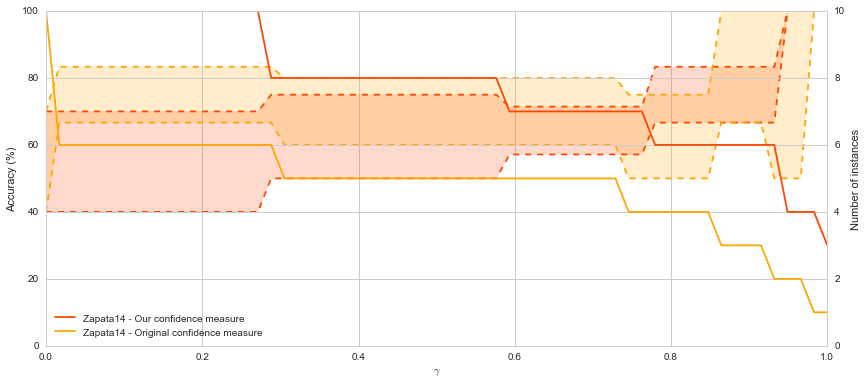

**Figure 3 - TOYDS **: Comparison of our proposed confidence measure with the confidence 
    measure proposed in [2] for TOYDS dataset and Zapata14 tempo estimation algorithm.
    


Confidence vs tempo estimation accuracy (fs_300)
------------------------------------------------



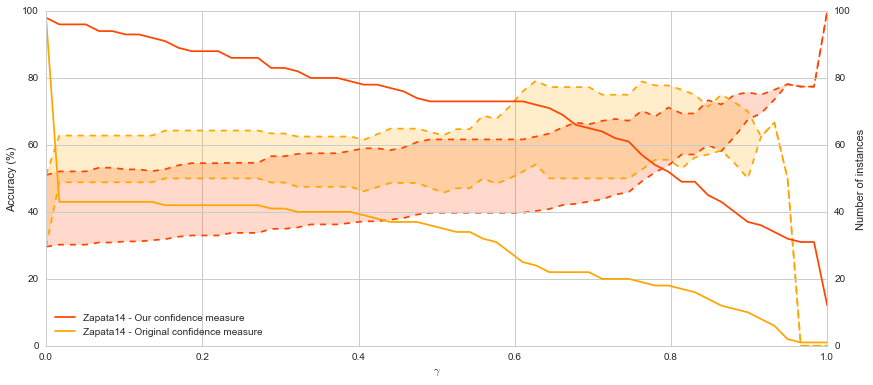

**Figure 3 - fs_300 **: Comparison of our proposed confidence measure with the confidence 
    measure proposed in [2] for fs_300 dataset and Zapata14 tempo estimation algorithm.
    

In [10]:
# Normalize confidence measure for Zapata14 so that numbers go from 0 to 1 and it is
# comparable with our confidence measure. We get the maximum and minimum value found in the dataset 
# and normalise the confidence to be in the [0, 1] range.
for dataset in datasets:    
    # Annotate all methods wirh confidence measures using the function above
    zapata_conf_values = dataset.get_data('analysis.Zapata14.confidence')
    if not zapata_conf_values:
        raise Exception('No information for Zapata14 method in dataset %s' % dataset.short_name)
    max_value = max(zapata_conf_values)
    min_value = min(zapata_conf_values)
    for key, item in dataset.data.items():
        try:
            normalised_value = float(item['analysis']['Zapata14']['confidence'] - min_value)/(max_value - min_value)
            item['analysis']['Zapata14']['confidence_zapata'] = normalised_value
        except KeyError:
            continue
            
CONFIDENCE_MEASURE_NAMES = {
    'confidence_ffont': 'Our confidence measure',
    'confidence_zapata': 'Original confidence measure'
}
        
for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    ax2 = ax1.twinx()
    methods_and_conf_to_compare = [('Zapata14', 'confidence_ffont'), 
                                   ('Zapata14', 'confidence_zapata')]
   
    for count, (method, conf_method) in enumerate(methods_and_conf_to_compare):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, conf_method), conf_min)]).data
                accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
                accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
                accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
        
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, 
                         color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label="%s - %s" % (method, CONFIDENCE_MEASURE_NAMES[conf_method]))

    print title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    plt.show()
    figure_caption = """**Figure 3 - %s **: Comparison of our proposed confidence measure with the confidence 
    measure proposed in [2] for %s dataset and Zapata14 tempo estimation algorithm.
    """ % (dataset.short_name, dataset.short_name)
    IPython.display.display(IPython.display.Markdown(figure_caption))

In [11]:
# Compute combined scores for Zapata14 method using confidence_ffont or confidence_zapata
# NOTE: to run this cell 'overall_method_score' must have been defined (see cells above)

methods_and_conf_to_compare = [('Zapata14', 'confidence_ffont'), 
                               ('Zapata14', 'confidence_zapata')]
for accuracy_func in accuracy1e, accuracy1, accuracy2:
    print title('Combined score results for %s' % accuracy_func.__name__)
    table_header = ['Method - Conf method'] + [dataset.short_name for dataset in datasets]
    table_rows = list()
    for method, conf_method in methods_and_conf_to_compare:
        table_row = list()
        table_row.append('%s - %s' % (method, conf_method))
        for dataset in datasets:
            accuracies = list()
            counts = list()
            steps = np.linspace(0, 1, 60)
            for conf_min in steps:
                try:
                    filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, conf_method), conf_min)]).data
                    if filtered_data:
                        accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                    else:
                        accuracies.append(0.00000001)  # Use very small number to avoid division by 0, in any case counts will be 0 to so overall_score will be 0
                    accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                    counts.append(len(filtered_data))
                except IndexError:
                    raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
            score = overall_method_score(accuracies, counts, dataset_size=len(dataset.data))
            table_row.append(score)
        table_rows.append(table_row)
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)


Combined score results for accuracy1e
-------------------------------------

Method - Conf method           TOYDS   
---------------------------------------
Zapata14 - confidence_ffont    0.55    
Zapata14 - confidence_zapata   0.53    

Combined score results for accuracy1
------------------------------------

Method - Conf method           TOYDS   
---------------------------------------
Zapata14 - confidence_ffont    0.67    
Zapata14 - confidence_zapata   0.59    

Combined score results for accuracy2
------------------------------------

Method - Conf method           TOYDS   
---------------------------------------
Zapata14 - confidence_ffont    0.73    
Zapata14 - confidence_zapata   0.59    
